<a href="https://colab.research.google.com/github/akanksha0911/MountainCar_Sarsa/blob/main/MountainCar_SARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [ ]:
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from mpl_toolkits.mplot3d import Axes3D
import sklearn.pipeline
import sklearn.preprocessing

In [ ]:
#importing the dependencies

import gym
import numpy as np

#exploring Mountain Car environment

env_name = 'MountainCar-v0'
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000


print("Action Set size :",env.action_space)
print("Observation set shape :",env.observation_space) 
print("Highest state feature value :",env.observation_space.high) 
print("Lowest state feature value:",env.observation_space.low) 
print(env.observation_space.shape)

Action Set size : Discrete(3)
Observation set shape : Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Highest state feature value : [0.6  0.07]
Lowest state feature value: [-1.2  -0.07]
(2,)


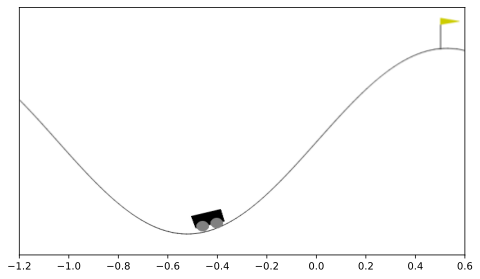

In [ ]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
env.reset()
frame = env.render(mode='rgb_array')

fig, ax = plt.subplots(figsize=(8, 6))
ax.axes.yaxis.set_visible(False)
ax.imshow(frame, extent=[env.min_position, env.max_position, 0, 1])

In [ ]:
print("Action Space {}".format(env.action_space))

Action Space Discrete(3)


In [ ]:
# The state consists of 2 numbers:
# - Car's position, from -1.2 to 0.6
# - Car's velocity, from -0.07 to 0.07
print("State Space {}".format(env.observation_space))

print(f'Position ranges from {env.min_position} to {env.max_position}')
print(f'Velocity ranges from {-env.max_speed} to {env.max_speed}')

State Space Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Position ranges from -1.2 to 0.6
Velocity ranges from -0.07 to 0.07


In [ ]:
num_episodes = 200
discount_factor = 1.0
alpha = 0.01
nA = env.action_space.n

In [ ]:
#Parameter vector define number of parameters per action based on featurizer size
w = np.zeros((nA,400))

# Plots
plt_actions = np.zeros(nA)
episode_rewards = np.zeros(num_episodes)

In [ ]:
# Get satistics over observation space samples for normalization
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

StandardScaler()

In [ ]:
# Create radial basis function sampler to convert states to features for nonlinear function approx
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
		])

In [ ]:
# Fit featurizer to our scaled inputs
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [ ]:
# Normalize and turn into feature
def featurize_state(state):
	# Transform data
	scaled = scaler.transform([state])
	featurized = featurizer.transform(scaled)
	return featurized

def Q(state,action,w):
	value = state.dot(w[action])
	return value

# Epsilon greedy policy
def policy(state, weight, epsilon=0.1):
	A = np.ones(nA,dtype=float) * epsilon/nA
	best_action =  np.argmax([Q(state,a,w) for a in range(nA)])
	A[best_action] += (1.0-epsilon)
	sample = np.random.choice(nA,p=A)
	return sample

# OPTIONAL check gradients 
def check_gradients(index,state,next_state,next_action,weight,reward):

	ew1 = np.array(weight, copy=True) 
	ew2 = np.array(weight, copy=True)  
	epsilon = 1e-6
	ew1[action][index] += epsilon
	ew2[action][index] -= epsilon
	
	test_target_1 = reward + discount_factor * Q(next_state,next_action,ew1)		
	td_error_1 = target - Q(state,action,ew1)

	test_target_2 = reward + discount_factor * Q(next_state,next_action,ew2)		
	td_error_2 = target - Q(state,action,ew2)

	grad = (td_error_1 - td_error_2) / (2 * epsilon)
	
	return grad[0]

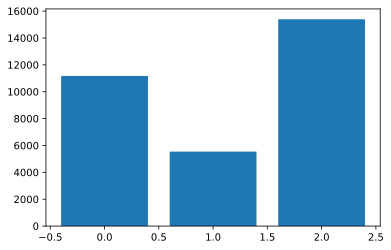

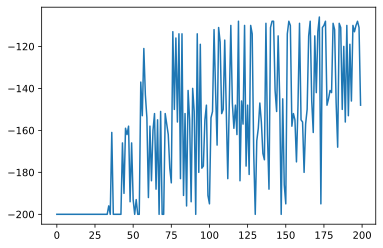

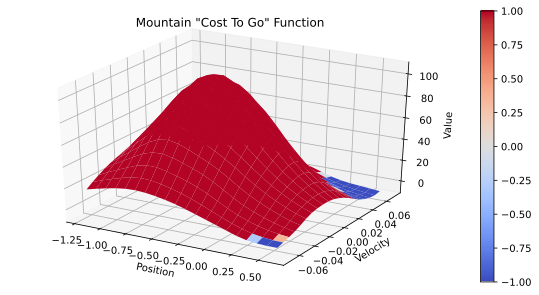

In [ ]:
# Our main training loop
for e in range(num_episodes):

	state = env.reset()
	state = featurize_state(state)

	while True:

		#env.render()
		# Sample from our policy
		action = policy(state,w)
		# Staistic for graphing
		plt_actions[action] += 1
		# Step environment and get next state and make it a feature
		next_state, reward, done, _ = env.step(action)
		next_state = featurize_state(next_state)

		# Figure out what our policy tells us to do for the next state
		next_action = policy(next_state,w)

		# Statistic for graphing
		episode_rewards[e] += reward

		# Figure out target and td error
		target = reward + discount_factor * Q(next_state,next_action,w)		
		td_error = Q(state,action,w) - target

		# Find gradient with code to check it commented below (check passes)
		dw = (td_error).dot(state)
		
		#for i in range(4):
		#	print("First few gradients")
		#	print(str(i) + ": " + str(check_gradients(i,state,next_state,next_action,w,reward)) + " " + str(dw[i]))

		# Update weight
		w[action] -= alpha * dw

		if done:
			break
		# update our state
		state = next_state

def plot_cost_to_go_mountain_car(num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max([Q(featurize_state(_),a,w) for a in range(nA)]), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


# Show bar graph of actions chosen
plt.bar(np.arange(nA),plt_actions)

plt.figure()
# Plot the reward over all episodes
plt.plot(np.arange(num_episodes),episode_rewards)
plt.show()
# plot our final Q function
plot_cost_to_go_mountain_car()

In [ ]:
env.close()